In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imread, imshow
import keras.backend as K

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [29]:
BATCH_SIZE = 1
NUM_EPOCHS = 3
IMAGE_SIZE = (256, 256)

In [3]:
train_dir = './datasets/train'
train_dataset = image_dataset_from_directory(train_dir, label_mode=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

validation_dir = './datasets/validation'
validation_dataset = image_dataset_from_directory(validation_dir, label_mode=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

test_dir = './datasets/test'
test_dataset = image_dataset_from_directory(test_dir, label_mode=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


(1, 256, 256, 3)


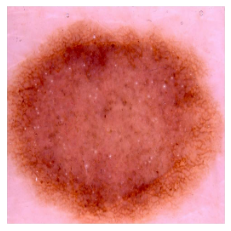

In [4]:
for images in train_dataset.take(1):
    print(images.shape)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
def preprocess_images_batch(image_batch):
    image_batch_lab = np.zeros_like((image_batch))
    for i in range(image_batch.shape[0]):
        image_batch_lab[i] = rgb2lab(image_batch[i] / 256)
    return image_batch_lab[:, :, :, 0:1] / 100, image_batch_lab[:, :, :, 1:3] / 128

In [7]:
from model import Unet
model = Unet().model()

-0.10976577 0.4458934


/home/user/Documents/fmi/4th/deep-learning/Image-Colorization/image-colorization/lib/python3.6/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 27725 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/home/user/Documents/fmi/4th/deep-learning/Image-Colorization/image-colorization/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


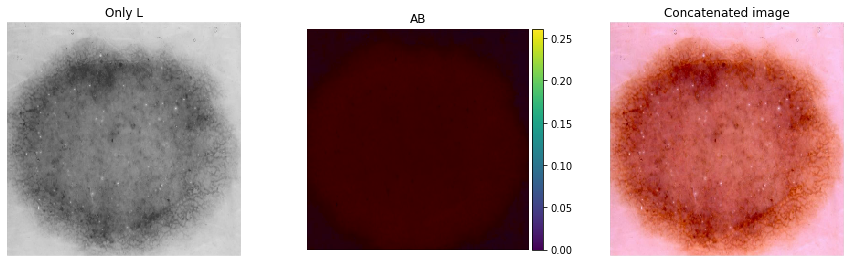

In [9]:
# test if preprocess is fine
for image_batch in train_dataset.take(1):
    l, ab = preprocess_images_batch(image_batch)
    print(np.amin(ab), np.amax(ab))

    a = ab[0,:,:,0] * 128
    l = l[0,:,:,0] * 100
    b = ab[0,:,:,1] * 128

    only_l = np.dstack((l, np.zeros(l.shape), np.zeros(l.shape)))
    ab = np.dstack((np.zeros(l.shape), a, b))  # doesn't make much sense as an image

    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    imshow(lab2rgb(only_l), ax=ax0), ax0.set_title('Only L'), ax0.axis('off')
    imshow(lab2rgb(ab), ax=ax1), ax1.set_title('AB'), ax1.axis('off'),
    imshow(lab2rgb(np.dstack((l, np.dstack((a, b))))), ax=ax2), ax2.set_title('Concatenated image'), ax2.axis('off')
    plt.show()

In [10]:
delta = 1
def l_delta_loss(y_true, y_pred):
    smaller = K.cast(K.abs(y_true - y_pred) < delta, tf.float32)
    bigger = 1 - smaller
    loss = K.sum(smaller * K.square(y_true - y_pred)) / 2 + delta * K.sum((K.abs(y_true - y_pred) - (delta / 2)))
    return loss

In [11]:
y_true = np.array([[2, 2], [2, 2]])
y_pred = np.array([[1, 1.5], [1, 1]])
l_delta_loss(y_true, y_pred)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul]

In [12]:
base_learning_rate = 0.0001
model.compile(loss=l_delta_loss,
              optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bw_conv1_1 (Conv2D)             (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
ab_conv1_1 (Conv2D)             (None, 256, 256, 64) 1792        input_1[0][0]                    
_______________________________________________________________________________________

In [14]:
l_wtf, _ = preprocess_images_batch(next(iter(validation_dataset)))
local_hints = np.ones((1, 256, 256, 3))
outaput_wtf = np.ones((1, 256, 256, 2))
print(l_wtf.shape, local_hints.shape, output_wtf.shape)

(1, 256, 256, 1) (1, 256, 256, 3) (1, 256, 256, 2)


In [32]:
class DatagGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, image_dataset, shuffle=False):
        self.batch_size = batch_size
        self.image_dataset = image_dataset
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return tf.data.experimental.cardinality(self.image_dataset)
    
    def __getitem__(self, index):
        for image_batch in self.image_dataset.skip(index).take(1):
            l, ab = preprocess_images_batch(image_batch)
        
        return [l, np.zeros((self.batch_size, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))], ab
    
    def on_epoch_end(self):
        if self.shuffle == True:
            self.image_dataset = self.image_dataset.shuffle(self.image_dataset.cardinality())

In [33]:
train_generator = DatagGenerator(batch_size=BATCH_SIZE, image_dataset=train_dataset, shuffle=True)
validation_generator = DatagGenerator(batch_size=BATCH_SIZE, image_dataset=validation_dataset)

In [36]:
history = model.fit(train_generator, epochs=NUM_EPOCHS, validation_data=validation_generator)

Epoch 1/3
1/1 [==============================] - 2s 2s/step - loss: -30001.7656 - accuracy: 0.9828 - val_loss: -30015.1562 - val_accuracy: 0.9828
Epoch 2/3
1/1 [==============================] - 2s 2s/step - loss: -30015.1562 - accuracy: 0.9828 - val_loss: -30028.5371 - val_accuracy: 0.9828
Epoch 3/3
1/1 [==============================] - 2s 2s/step - loss: -30028.5371 - accuracy: 0.9828 - val_loss: -30041.9180 - val_accuracy: 0.9828


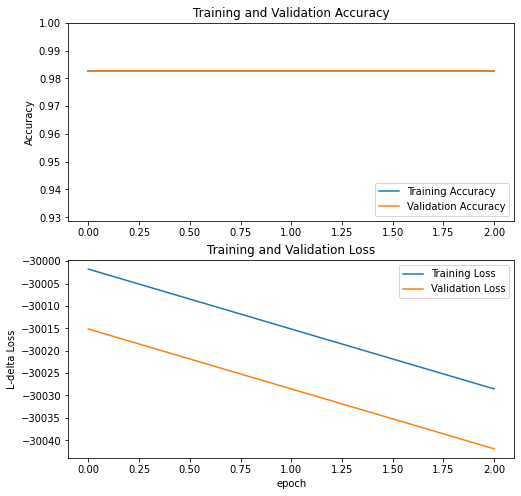

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('L-delta Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()